# KEY: Transfer Learning

**It is recommended that you complete this notebook in Google Colab:**
- otherwise you may encounter errors
- this will allow you to access free GPU resources

---
In this notebook, we'll use transfer learning to train the CNN, **Inception v3** to classify images of flowers. A very similar process was used by Esteva et al. to classify skin lesions.

**This notebook should be completed using a GPU runtime in Colab.**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import cv2

# torch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

**Check if GPU is is being used**

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.4.1+cu118
11.8


Let's begin by using `torchvision` to load Inception v3.

**More Info on Inception v3**: Can be found in `torchvision` documentation (https://pytorch.org/vision/stable/models/generated/torchvision.models.inception_v3.html)

**Important Note**: This is a *different* version of Inception v3 compared to the one we used in an earlier activity. In this version, the final layer (i.e. the *classification head*) has been removed.

We are removing the fully connected (classification) layer because we are only interested in **feature extraction**. We remove the fully connected layer by turning the fully connected layer in `inception_v3` into a identity matrix. By changing the fully connected layer to a identity matrix, the layer now has no effect on the model. This results in the model lacking the fully connected layer. 

Additionally, we need to remove the **auxillary classifiers**. The purpose of the auxillary classifier is to push useful gradients to lower layers of the model, to improve convergence during training. However, for our example of `inception_v3` we wish to freeze the model, so auxillary classifiers are not needed. The code below disables all the auxillary classifiers (even for training), and removes the auxillary logits from the model so they can't be accidentally turned on.


In [3]:
from torchvision import models


# load the module
inception_v3 = models.inception_v3(pretrained=True)

# freeze parameters
for param in inception_v3.parameters():
    param.requires_grad = False

# modify model to output features, instead of predictions
inception_v3.fc = nn.Identity() # remove fully connected layer

# remove auxillary classifier
if inception_v3.aux_logits:
    inception_v3.aux_logits = False
    inception_v3.AuxLogits = None

/hpc/home/mgf24/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hpc/home/mgf24/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Part 1: Identifying Flowers

In the first half of this activity, we'll re-train the final layer of Inception v3 to identify several types of flowers. We begin by downloading the dataset as seen below.

In [4]:
import urllib.request
import tarfile


# download path
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
download_path = './flower_photos.tgz'
extract_path = './flower_photos' # create folder flower_photos in working directory

# download data
if not os.path.exists(download_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, download_path)
    print("Download complete.")


# extract data
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(download_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")



print("Dataset is ready at", extract_path)


Dataset is ready at ./flower_photos


Now we can load the dataset from the created folder `flower_photos`.
1. Load all training images into batches of size 32, with their associated labels.The labels are determined by the directory structure in the archive we downloaded.
2. Resize all images to (299,299) as required by `Inception v3`.
3. Convert all images and labels to **tensors**
4. Divide the data into training and test sets.

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


# load data
flower_root='./flower_photos/flower_photos'

# setup classes
FLOWER_CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


INPUT_SIZE = 299


# create transformation (for image size, and tensor)
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=flower_root, transform=transform)

# check class names
class_names = dataset.classes
print(f"Class names: {class_names}")




Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


We can now create a 80/20 training and test split. In each dataset the batch size will be 32.
- We do not need to normalize our data, because it happens automatically when using `transforms.ToTensor()` in the `transform` method above.

In [6]:
# create training/test split
total_size = len(dataset)
test_size = int(total_size *.2)
train_size = total_size - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

# create batch size of 32
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# check batches

print(f"Total dataset size: {total_size}")
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")
print(f"\nTotal number of batches in train_loader: {math.ceil(train_size / 32)}")
print(f"Total number of batches in test_loader: {math.ceil(test_size / 32)}")




Total dataset size: 3670
Training set size: 2936
Test set size: 734

Total number of batches in train_loader: 92
Total number of batches in test_loader: 23


## Exercise 8.1: Visualize the Flowers Dataset

Similar to previous exercises, we can use `plt.imshow` to plot images in a batch generated by our `train_loader` Dataset. 

In the following block, you should plot and label these images.

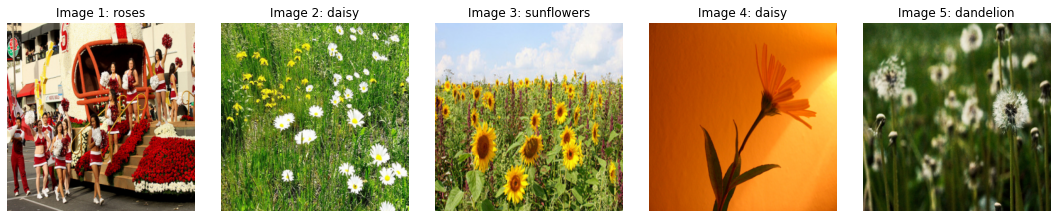

In [7]:
# Create a figure with 5 subplots
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

# Get a single batch from the train dataset
images, labels = next(iter(train_loader))

# Loop through the first 5 images in the batch
for i in range(5):
    # We must change the image from (Channels, Height, Width) to (Height, Width, Channels), and convert it to a NumPy array.
    image = images[i].permute(1, 2, 0).numpy()

    # Plot the image
    ax[i].imshow(image)

    # Set the title for the image with the corresponding label
    ax[i].set_title(f"Image {i+1}: {FLOWER_CLASSES[labels[i]]}")

    # Turn off the axis for a cleaner image
    ax[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


We're now ready to create our prediction model following the steps described in our [medical image analysis lecture](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/ll3.pdf):
- Start with our Inception v3 feature extractor. We have already removed the classification head (final connected layer) above, but we like to add a new fully connected layer.
-  The new fully connected layer will be used to predict the image label (flower type) based on the extracted features. We will be learning the weights in this new layer.
- We can now use `summary()` to see a description of our model. It is very long, because we can see each individual layer of the `inception_v3` model.
---
**In the Code Below**:
1. We first create the class `FeatureExtractorWrapper` using the library torch.nn. This`FeatureExtractorWrapper` class is used as a wrapper for our InceptionV3 model. We use the wrapper because we wish to isolate feature extraction. It takes the `inception_v3` model we created as an input and outputs the model after applying the feature extractor wrapper.
   
3. We next create the class `CustomInceptionV3`. This class takes the input of the `feature_extractor`, and number of classes and outputs the new model, after adding a new fully connected layer. The new fully connected layer takes an input of 2048 features, and outputs a feature for each class for our data set. By adding this fully connected layer, we can  predict the flower type for each flower image.

In [8]:


# feature extractor wrapper to extract features using InceptionV3
class FeatureExtractorWrapper(nn.Module):
    def __init__(self, feature_extractor):
        super(FeatureExtractorWrapper, self).__init__()
        self.feature_extractor = feature_extractor

    def forward(self, x):
        return self.feature_extractor(x)


# Custom Model with Feature Extraction and Classification
class CustomInceptionV3(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super(CustomInceptionV3, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(2048, num_classes)  # Final dense layer for classification

    def forward(self, x):
        # Feature extraction step
        with torch.no_grad():
            x = self.feature_extractor(x)
        x = self.classifier(x)  # Final classification layer
        return x

# apply feature wrapper on inceptionv3
feature_extractor = FeatureExtractorWrapper(inception_v3)

num_classes = len(FLOWER_CLASSES)


# Initialize the model
model = CustomInceptionV3(feature_extractor, num_classes)


Before running the model, its helpful to check the total parameters, trainable parameters, and non-trainable parameters.

In [9]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params


print(f"Total number of parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total number of parameters: 21795813
Trainable parameters: 10245
Non-trainable parameters: 21785568


To begin training, we'll first need to define our loss, and our optimizer, just as we did in our previous computational exercise.

In [10]:
loss_object = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Exercise 8.2: Train the Flowers Model and Evaluate Performance

We're now ready to train our model, which we can do with the following block. Again, this is identical to code we used in the previous exercise. However, this time you should **make the following adjustments**:
- Try training for more epochs
- Add code to monitor accuracy on the training set and test set after each epoch
- After the training process has completed, plot training and test performance by epoch. Is your model overfitting?

In [11]:
num_epochs=10

for epoch in range(num_epochs):
    train_accuracy = []
    test_accuracy = []

    model.train()
# training loop
    for images, labels in train_loader:

# zero gradients
        optimizer.zero_grad()

# forward pass
        predictions= model(images)
        loss=loss_object(predictions, labels)
        loss.backward()
# backward pass
        optimizer.step()

# Calculate accuracy
        _, predicted = torch.max(predictions, 1)  # Get predicted class indices
        train_accuracy.append((predicted == labels).float().mean().item())

# evaluation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, labels in test_loader:
            # Forward pass
            predictions = model(images)

            # Calculate test accuracy
            _, predicted = torch.max(predictions, 1)  # Get predicted class indices
            test_accuracy.append((predicted == labels).float().mean().item())

    # calculate accuracy
    train_accuracy = 100 * torch.mean(torch.tensor(train_accuracy)).item()
    test_accuracy = 100 * torch.mean(torch.tensor(test_accuracy)).item()
    print(f'Epoch {epoch}: train accuracy = {train_accuracy:.1f}%, test accuracy = {test_accuracy:.1f}%')

Epoch 0: train accuracy = 66.6%, test accuracy = 82.0%
Epoch 1: train accuracy = 81.5%, test accuracy = 84.5%
Epoch 2: train accuracy = 82.9%, test accuracy = 84.9%
Epoch 3: train accuracy = 84.4%, test accuracy = 86.1%
Epoch 4: train accuracy = 85.5%, test accuracy = 87.2%
Epoch 5: train accuracy = 86.9%, test accuracy = 88.3%
Epoch 6: train accuracy = 87.0%, test accuracy = 88.2%
Epoch 7: train accuracy = 87.4%, test accuracy = 88.2%
Epoch 8: train accuracy = 87.9%, test accuracy = 88.0%
Epoch 9: train accuracy = 87.2%, test accuracy = 87.6%


## Exercise 8.3: Make Predictions and Inspect Them

We're done training! We've already taken a look at the accuracy, but let's also inspect a few images in the test set. In the following block, you should plot at least 5 test images along with (a) the predicted label, and (b) the true label.

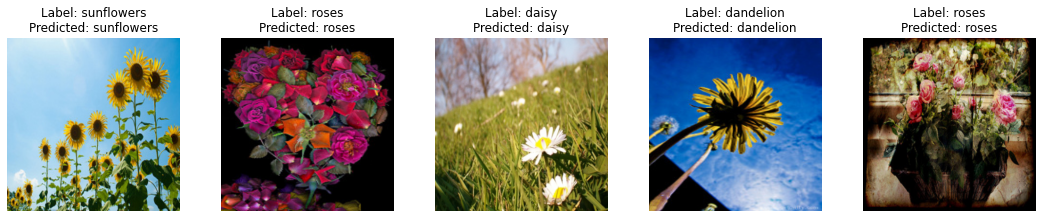

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

images, labels = next(iter(test_loader))



## ADD CODE TO PREDICT THE LABELS FOR THIS BATCH OF TEST IMAGES ##
predicted_labels = torch.argmax(model(images), dim=1)

for i in range(5):
    
  ## ADD CODE TO PLOT THE IMAGE ##
  img = images[i].cpu().permute(1, 2, 0).numpy() # re-order 
  ax[i].imshow(img)

  ## ADD CODE TO TITLE THE IMAGE WITH THE PREDICTED AND TRUE LABELS ##
  ax[i].set_title('Label: %s\nPredicted: %s' % (FLOWER_CLASSES[labels[i]], FLOWER_CLASSES[predicted_labels[i]]))

  # turn off the axes to make the images look nicer
  ax[i].axis('off')

plt.tight_layout()
plt.show()

## Part 2: Mammograms

In the second half of this activity, we'll re-train the final layer of Inception v3 to identify types of breast tissue from [the mini-MIAS database of mammograms](http://peipa.essex.ac.uk/info/mias.html). This dataset is very small, which makes it easy to work with in a short amount of time. While we're unlikely to get good accuracy with a dataset of this size, the same process could be used to obtain good performance on a larger dataset. We'll begin by downloading the data the same way we downloaded the flowers dataset.

In [13]:
# download path
url = 'http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz'
download_path = 'all-mias.tar.gz'
extract_path = './mias_dataset'

# download data
if not os.path.exists(download_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, download_path)
    print("Download complete.")


# extract data
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(download_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")



print("Dataset is ready at", extract_path)

Dataset is ready at ./mias_dataset


**Now lets load the dataset**

We can now build our dataset from the downloaded files. This time, we'll build the dataset manually instead of using a function. This will make it easier to see all the individual steps, but will use more RAM than we did before, because all the images will be stored in memory. Steps include:
- Load all images in the directory we downloaded using `cv2`.
- Resize all images to (299, 299) and rescale their pixels to range from 0 to 1, as required for Inception v3.
- Convert the images and labels to PyTorch tensors ready to be fed through a PyTorch graph.
- Use pandas to read a table containing information corresponding to each image, including the tissue type and severity of any abnormalities. We will be predicting tissue type rather than severity, because the latter only exists for images that contain abnormalities.
- Divide the data into training and test sets.

**The details of the code in this block are not important, but it is important that you understand why these steps above are needed.**

After running this block, you may want to take a look at `mias_df`, which contains information about each image, as well as the shape of `mias_images`.

In [14]:
from torch.utils.data import TensorDataset
import cv2
mias_root='./mias_dataset/mias_dataset'

INPUT_SIZE = 299
def read_image(fn, size=(INPUT_SIZE, INPUT_SIZE)):
  img = cv2.imread(fn)[:, :, ::-1] # Read in image, and convert from BGR(blue, green, red) to RGB(red, green, blue)
  img = cv2.resize(img, size) # Resize image to 299*299
  return img / 255. # normalize each image to range [0,1]

mias_df = pd.read_table(
    os.path.join(os.path.dirname(mias_root), 'Info.txt'),
    sep=' ',
    skiprows=101,
    skipfooter=2,
    header=None,
    engine='python',
    names=['id', 'tissue', 'type', 'severity', 'x_coord', 'y_coord', 'radius']
)[['id', 'tissue', 'type']].drop_duplicates().sample(frac=1., random_state=2021) # drop all columns besides ['id', 'tissue', 'type']

mias_filenames = os.listdir(os.path.dirname(mias_root))
mias_ids = [fn.split('.')[0] for fn in mias_filenames]
mias_df = mias_df[mias_df['id'].isin(mias_ids)]

mias_labels, mias_classes = pd.factorize(mias_df['tissue'])
mias_images = np.array([read_image(os.path.join(os.path.dirname(mias_root), str(id) + '.pgm')) for id in mias_df['id']])

batch_size = 23
split_point = 23 * 12 #split the data based on the 276 sample

# Split the dataset into training and testing
train_images, test_images = mias_images[:split_point], mias_images[split_point:] # first 276 images go into training, rest go into test
train_labels, test_labels = mias_labels[:split_point], mias_labels[split_point:]


# Convert Images and Labels to PyTorch Tensors
train_images = torch.tensor(train_images, dtype=torch.float32).permute(0, 3, 1, 2)  # Change shape of the tensor to (Number, Channels, Height, Width)
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)

train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check shape  
for images, labels in train_loader:
    batch_size, channels, height, width = images.shape  # Unpack the shape
    label_size=labels.shape[0]
    print(f"Shape of Images")
    print(f"Batch Size: {batch_size}")
    print(f"Channels: {channels}")
    print(f"Height: {height}")
    print(f"Width: {width}")
    print(f"\nShape of Labels")
    print(f"Label Size: {label_size}")
    break  # Exit after the first batch


Shape of Images
Batch Size: 23
Channels: 3
Height: 299
Width: 299

Shape of Labels
Label Size: 23


## Exercise 8.4: Visualize the mini-MIAS Dataset

This time, even though we did create Pytorch Tensorflow Datasets to use in training (`train_loader` and `test_loader`), we can also access the images and labels directly in `mias_images` and `mias_labels`, and `mias_classes` tells us the tissue type corresponding to each label. In the following block, you should plot and label at least 5 images from mini-MIAS.

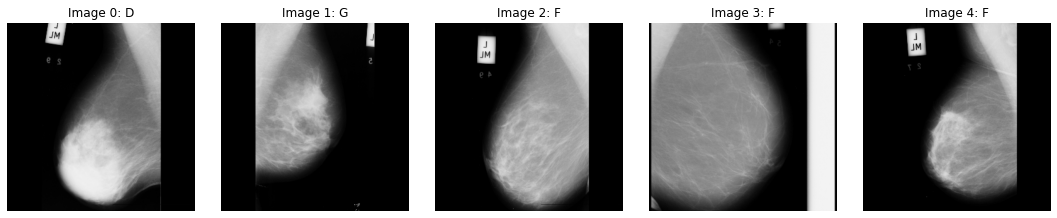

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i in range(5):

  ## ADD CODE TO PLOT THE IMAGE ##
  ax[i].imshow(mias_images[i])

  ## ADD CODE TO TITLE THE IMAGE WITH THE CORRESPONDING LABEL ##
  ax[i].set_title('Image %i: %s' % (i, mias_classes[mias_labels[i]]))

  # turn off the axes to make the images look nice
  ax[i].axis('off')

plt.tight_layout()
plt.show()

Once again, we're ready to create our prediction model following the steps described in our [medical image analysis lecture](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/ll3.pdf):
- Start with our Inception v3 feature extractor. The classification head (i.e. final layer) has already been removed, but we do need to convert this from a Tensorflow Hub model to a Layer object that can be incorporated in our new, flower prediction model.
- We'll stick with `trainable=False`. It may be interesting to try `trainable=True`, but it's unlikely to work well with such a small dataset. If we had a large enough dataset to support this, we'd need a lot more time.
- Add a Dense (i.e. fully-connected) layer that will predict the image label (i.e. tissue type) based on the extracted features. We will be learning the weights in this new layer.

We can now use `model.summary()` to see a description of our model. Again, our single `inception_v3` is actually the entire Inception v3 CNN, which is why it contains so many parameters.

In [16]:
num_classes=len(mias_classes)

model = nn.Sequential(
    inception_v3,
    nn.Linear(in_features=2048, out_features=num_classes)
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params


print(f"Total number of parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")


Total number of parameters: 21791715
Trainable parameters: 6147
Non-trainable parameters: 21785568


We'll use the same loss and optimizer as before.

In [17]:
loss_object = nn.CrossEntropyLoss() # multi-class cross-entropy loss
optimizer = optim.Adam(model.parameters()) #modified stochastic gradient descent optimizer

## Exercise 8.5: Train the MIAS Model and Evaluate Performance

Now we're ready to start training! You should modify the code below the same way you did before:
- Evaluate accuracy on the training set and test set after each epoch
- Additionally, it may be helpful to evaluate performance on the test set before we start training so we know what our starting point is.

In [18]:
num_epochs=10

for epoch in range(num_epochs):
    train_accuracy = []
    test_accuracy = []

    model.train()
# training loop
    for images, labels in train_loader:

# zero gradients
        optimizer.zero_grad()

# forward pass
        predictions= model(images)
        loss=loss_object(predictions, labels)
        loss.backward()
# backward pass
        optimizer.step()

# Calculate accuracy
        _, predicted = torch.max(predictions, 1)  # Get predicted class indices
        train_accuracy.append((predicted == labels).float().mean().item())

# evaluation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, labels in test_loader:
            # Forward pass
            predictions = model(images)

            # Calculate test accuracy
            _, predicted = torch.max(predictions, 1)  # Get predicted class indices
            test_accuracy.append((predicted == labels).float().mean().item())

    # calculate accuracy
    train_accuracy = 100 * torch.mean(torch.tensor(train_accuracy)).item()
    test_accuracy = 100 * torch.mean(torch.tensor(test_accuracy)).item()
    print(f'Epoch {epoch}: train accuracy = {train_accuracy:.1f}%, test accuracy = {test_accuracy:.1f}%')

Epoch 0: train accuracy = 36.2%, test accuracy = 30.4%
Epoch 1: train accuracy = 44.2%, test accuracy = 43.5%
Epoch 2: train accuracy = 62.3%, test accuracy = 47.8%
Epoch 3: train accuracy = 77.2%, test accuracy = 54.3%
Epoch 4: train accuracy = 72.8%, test accuracy = 58.7%
Epoch 5: train accuracy = 73.9%, test accuracy = 58.7%
Epoch 6: train accuracy = 76.8%, test accuracy = 60.9%
Epoch 7: train accuracy = 78.3%, test accuracy = 58.7%
Epoch 8: train accuracy = 84.4%, test accuracy = 60.9%
Epoch 9: train accuracy = 81.9%, test accuracy = 60.9%


When training a model like this, in addition to the fact that you'll typically be working with a much larger dataset, there are a few additional factors to consider, including:
- The depth to which you'll fine-tune. To adjust this, we'd need code to set individual layers within Inception v3 to trainable or not, rather than Inception v3 as a whole.
-  Data augmentation, which typically includes random crops, rotations, and other distortions.

Still, this code provides the general road map you'd need to make predictions on your own dataset of medical images.

## Steps to distribute your work as an html file:

If you're using Anaconda on your local machine:
- download your notebook as html (see `File > Download as > HTML (.html)`)

If you're using Google Colab:
- download your notebook as .ipynb (see `File > Download > Download .ipynb`)
- if you have nbconvert installed, convert it to .html and submit it in Talent LMS
- if not, you may need to place the .ipynb file in a .zip archive in order to distribute it (e.g. to upload or send via email)